In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyeit import mesh
import os
from glob import glob

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from src.vae_model import vae_model
from sklearn.model_selection import train_test_split
from src.util import (plot_mesh_permarray, load_all_data)


2024-12-03 17:52:58.531115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733248378.544666 1410442 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733248378.548823 1410442 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 17:52:58.564859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1733248385.066419 1410442 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

In [2]:
n_el = 16  
mesh_obj = mesh.create(n_el, h0=0.05)

In [3]:
voltage_dict, gamma_dict, anomaly_dict = load_all_data()

In [4]:
gamma = gamma_dict["gamma1"]/15

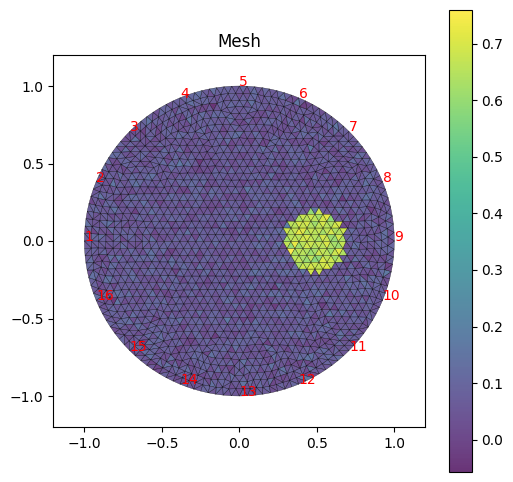

In [5]:
plot_mesh_permarray(mesh_obj, gamma[0,:,0])


In [6]:
vae = vae_model()
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [7]:
#vae.encoder.summary()

In [8]:
#vae.decoder.summary()

In [9]:
gamma_train, gamma_test = train_test_split(gamma, test_size=0.2, random_state=42)

In [10]:
gamma.shape, gamma_train.shape, gamma_test.shape

((40000, 2821, 1), (32000, 2821, 1), (8000, 2821, 1))

In [11]:
gamma_train.shape[1:]

(2821, 1)

In [12]:
input_shape = gamma_train.shape[1:]  # Form der Eingabedaten ohne Batch-Dimension
vae.build(input_shape=(None, *input_shape))
history_vae = vae.fit(gamma_train, epochs=30, batch_size=32, validation_split=0.1)
print(f"Modell gebaut: {vae.built}")

Epoch 1/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 60s 60ms/step - kl_loss: 4.2595 - loss: 31.1617 - reconstruction_loss: 26.9022 - val_kl_loss: 6.9551 - val_loss: 20.1200 - val_reconstruction_loss: 13.1649
Epoch 2/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - kl_loss: 7.3078 - loss: 19.6787 - reconstruction_loss: 12.3709 - val_kl_loss: 7.8109 - val_loss: 18.4174 - val_reconstruction_loss: 10.6065
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - kl_loss: 7.2135 - loss: 18.0944 - reconstruction_loss: 10.8810 - val_kl_loss: 7.3394 - val_loss: 17.4007 - val_reconstruction_loss: 10.0613
Epoch 4/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - kl_loss: 7.2541 - loss: 17.3390 - reconstruction_loss: 10.0849 - val_kl_loss: 7.1723 - val_loss: 16.8594 - val_reconstruction_loss: 9.6871
Epoch 5/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 53s 59ms/step - kl_loss: 7.2664 - loss: 16.8520 - reconstruction_loss: 9.5856 - val_kl_loss: 6.8085 - val_loss: 16.5552 - val_reconstruction_loss: 9.7467
Epoch 6/30
900/900 ━━━━

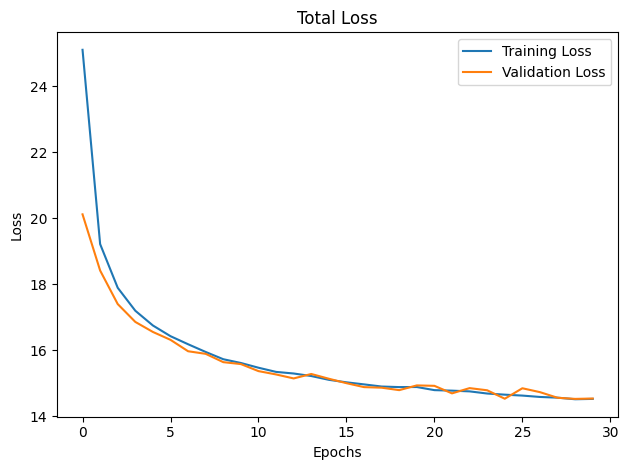

In [13]:
plt.plot(history_vae.history["loss"], label="Training Loss")
plt.plot(history_vae.history["val_loss"], label="Validation Loss")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

#20.000 scheint gut zu sein
#0. und 1. Position plotten und Perm_array voneinander abziehen
#Rauschen und Variation in Radius mit einbauen, um VAE besser zu generalisieren

In [21]:
weights_dir = "weights/"
os.makedirs(weights_dir, exist_ok=True)
vae_weights_file = os.path.join(weights_dir, "vae.weights.h5")
vae.save_weights(vae_weights_file)
print(f"Gewichte gespeichert unter: {vae_weights_file}")

Gewichte gespeichert unter: weights/vae.weights.h5


In [22]:
vae = vae_model()  # Erstelle die gleiche Modellinstanz
vae.build(input_shape=(None, *gamma_train.shape[1:]))  # Baue das Modell mit der passenden Eingabeform
vae.load_weights("weights/vae1.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [23]:
z_mean, z_log_var, z = vae.encoder.predict(gamma_test)
gamma_hat = vae.decoder.predict(z) * 15

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


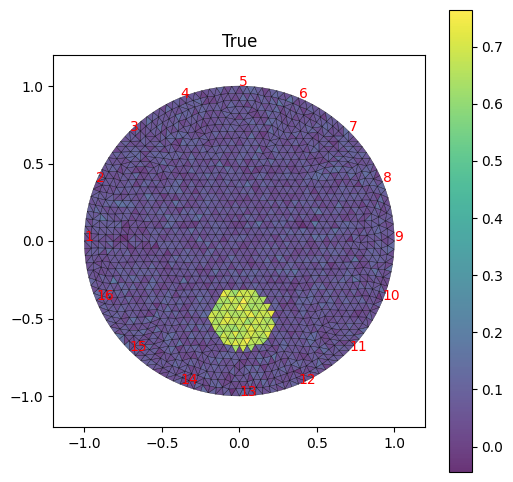

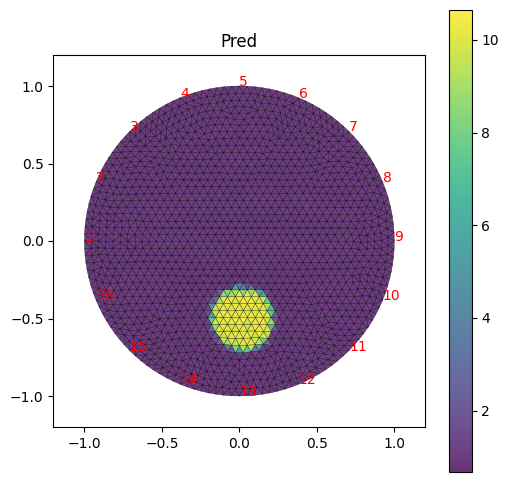

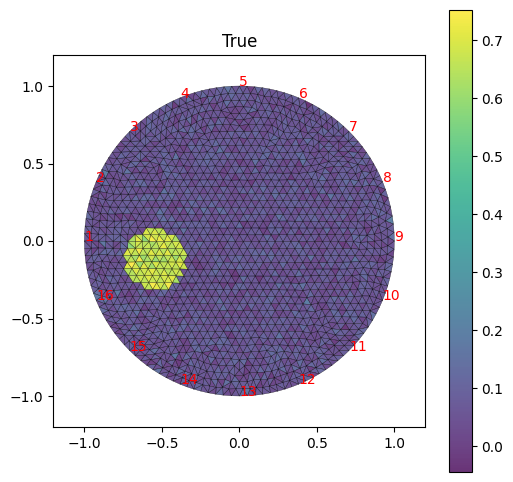

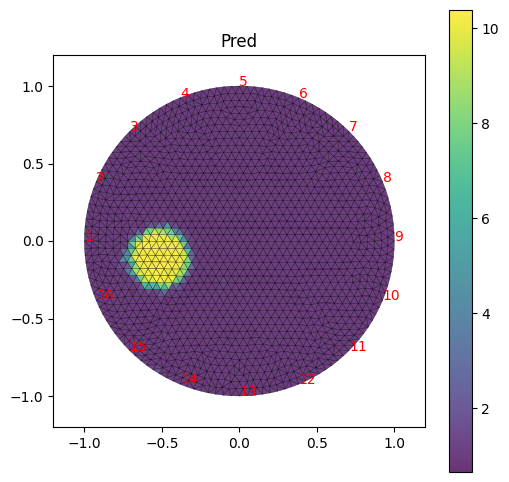

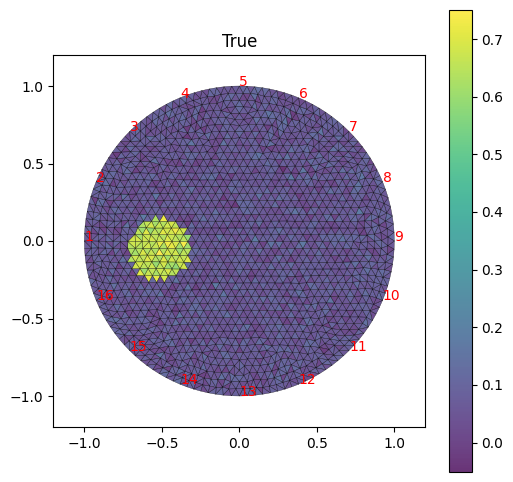

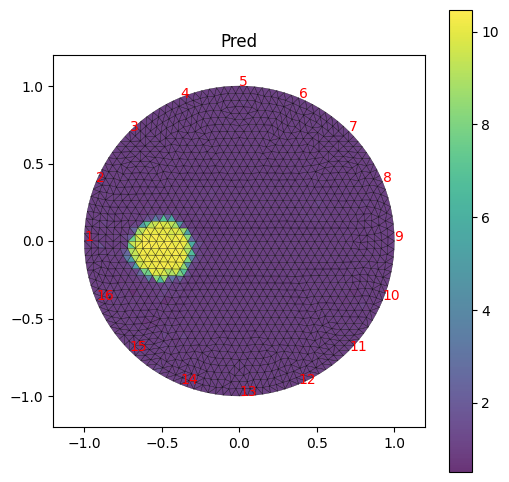

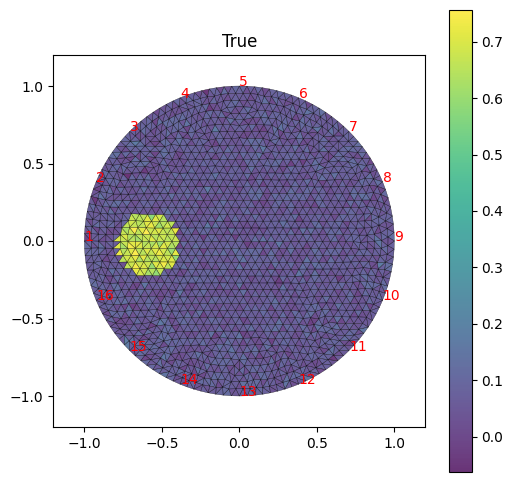

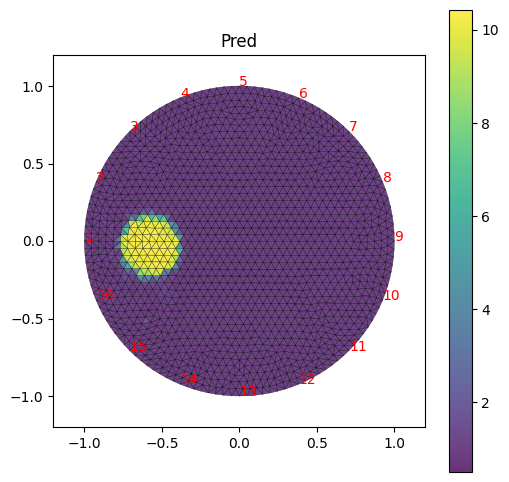

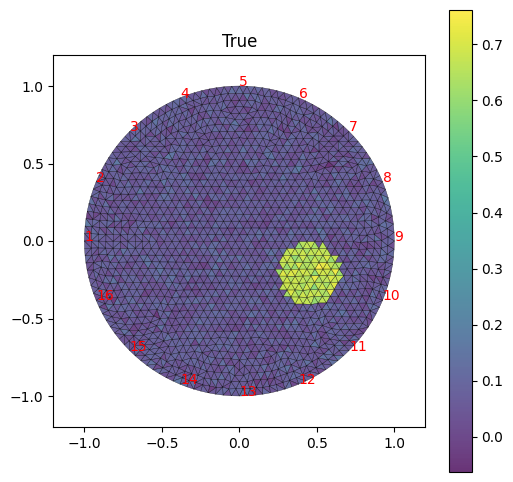

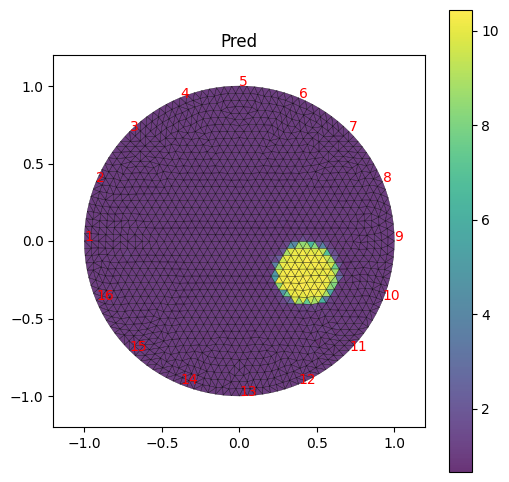

In [24]:
for idx in np.random.randint(0, high=gamma_test.shape[0], size=5):
    plot_mesh_permarray(mesh_obj, gamma_test[idx, :, 0], title="True")
    plot_mesh_permarray(mesh_obj, gamma_hat[idx, :, 0], title="Pred")